In [1]:
from pathlib import Path

parent_dir = str(Path.cwd().parent)
%cd $parent_dir

/Users/tomtalpir/Random/pyERGM


In [2]:
from pyERGM.utils import *
from pyERGM.ergm import ERGM, ConvergenceTester
from pyERGM.metrics import *

from pyERGM.datasets import sampson_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

import itertools

# Test #1 - Convergence in a perfect sample from an MPLE model

In [3]:
metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree()]

n_nodes = sampson_matrix.shape[0]

mple_model = ERGM(n_nodes, metrics, is_directed=True)
mple_model.fit(sampson_matrix, mple_lr=0.5)

Removing the 0 feature of outdegree to fix multi-collinearity
Removing the 0 feature of indegree to fix multi-collinearity
MPLE with lr 0.5
Logistic regression optimization started
Iteration 0, log-likelihood: -442.1827286887271, time from start: 1.1531304579693824 seconds, lr: 0.5
Iteration 1, log-likelihood: -172.4098979297536, time from start: 1.1593284159898758 seconds, lr: 0.5
Iteration 2, log-likelihood: -166.29645121247756, time from start: 1.168667082907632 seconds, lr: 0.5
Iteration 3, log-likelihood: -164.48422598082374, time from start: 1.1749730829615146 seconds, lr: 0.5
Iteration 4, log-likelihood: -163.93489328866372, time from start: 1.1760204159654677 seconds, lr: 0.5
Iteration 5, log-likelihood: -163.77571342296062, time from start: 1.1824307499919087 seconds, lr: 0.5
Iteration 6, log-likelihood: -163.7318974850064, time from start: 1.1899745829869062 seconds, lr: 0.5
Iteration 7, log-likelihood: -163.72030688606134, time from start: 1.1921376660466194 seconds, lr: 0.5

(None, None)

In [5]:
experiment_results = []

sample_sizes = [200, 1000, 5000, 10000]

n_attempts_per_experiment = 10

hotelling_hyperparams = {
    "confidence": [0.5, 0.95],
    "cov_matrix_estimation_method": ["naive", "batch"],
    "sample_sizes": sample_sizes
}



### Hotelling

In [43]:
hyperparams_keys = list(hotelling_hyperparams.keys())
hyperparams_values = list(hotelling_hyperparams.values())

all_hyperparams = list(itertools.product(*hyperparams_values))
for i, hyperparams in enumerate(all_hyperparams):
    hyperparams = dict(zip(hyperparams_keys, hyperparams))
    print(f"Working on hyperparams {i+1}/{len(all_hyperparams)}")
    print(hyperparams)

    sample_size = hyperparams["sample_sizes"]
    hotelling_confidence = hyperparams["confidence"]
    cov_matrix_estimation_method = hyperparams["cov_matrix_estimation_method"]

    for j in range(n_attempts_per_experiment):
        print(f"\tAttempt: {j+1}/{n_attempts_per_experiment}")
        observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)

        sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        sample_features = mple_model._metrics_collection.calculate_sample_statistics(sample_from_mple)
        mean_features = np.mean(sample_features, axis=1)
        estimated_cov_matrix = covariance_matrix_estimation(sample_features, mean_features, method=cov_matrix_estimation_method)
        inv_estimated_cov_matrix = np.linalg.pinv(estimated_cov_matrix)

        convergence_tester = ConvergenceTester()

        hotelling_result = convergence_tester.hotelling(observed_features, 
                                                        mean_features, 
                                                        inv_estimated_cov_matrix, 
                                                        sample_size, 
                                                        hotelling_confidence)
        
        experiment_results.append({
            "test_type": "Hotelling",
            "sample_size": sample_size,
            "test_statistic": hotelling_result["statistic"],
            "test_critical_value": hotelling_result["threshold"],
            "diff": hotelling_result["statistic"] - hotelling_result["threshold"],
            "success": hotelling_result["success"],
            "confidence": hotelling_confidence,
            "cov_matrix_estimation_method": cov_matrix_estimation_method,
        })



Working on hyperparams 1/16
{'confidence': 0.5, 'cov_matrix_estimation_method': 'naive', 'sample_sizes': 200}
	Attempt: 1/10
	Attempt: 2/10
	Attempt: 3/10
	Attempt: 4/10
	Attempt: 5/10
	Attempt: 6/10
	Attempt: 7/10
	Attempt: 8/10
	Attempt: 9/10
	Attempt: 10/10
Working on hyperparams 2/16
{'confidence': 0.5, 'cov_matrix_estimation_method': 'naive', 'sample_sizes': 1000}
	Attempt: 1/10
	Attempt: 2/10
	Attempt: 3/10
	Attempt: 4/10
	Attempt: 5/10
	Attempt: 6/10
	Attempt: 7/10
	Attempt: 8/10
	Attempt: 9/10
	Attempt: 10/10
Working on hyperparams 3/16
{'confidence': 0.5, 'cov_matrix_estimation_method': 'naive', 'sample_sizes': 5000}
	Attempt: 1/10
	Attempt: 2/10
	Attempt: 3/10
	Attempt: 4/10
	Attempt: 5/10
	Attempt: 6/10
	Attempt: 7/10
	Attempt: 8/10
	Attempt: 9/10
	Attempt: 10/10
Working on hyperparams 4/16
{'confidence': 0.5, 'cov_matrix_estimation_method': 'naive', 'sample_sizes': 10000}
	Attempt: 1/10
	Attempt: 2/10
	Attempt: 3/10
	Attempt: 4/10
	Attempt: 5/10
	Attempt: 6/10
	Attempt: 7/1

In [49]:
df

,test_type,sample_size,test_statistic,test_critical_value,diff,success,confidence,cov_matrix_estimation_method
0,Hotelling,200,1.413568,0.985000,0.428568,False,0.50,naive
1,Hotelling,200,1.344284,0.985000,0.359284,False,0.50,naive
2,Hotelling,200,0.802246,0.985000,-0.182753,True,0.50,naive
3,Hotelling,200,0.827924,0.985000,-0.157075,True,0.50,naive
4,Hotelling,200,1.214586,0.985000,0.229586,False,0.50,naive
...,...,...,...,...,...,...,...,...
155,Hotelling,10000,1.195497,0.641519,0.553978,False,0.95,batch
156,Hotelling,10000,1.502025,0.641519,0.860506,False,0.95,batch
157,Hotelling,10000,1.328387,0.641519,0.686868,False,0.95,batch
158,Hotelling,10000,1.361425,0.641519,0.719907,False,0.95,batch


<Axes: >

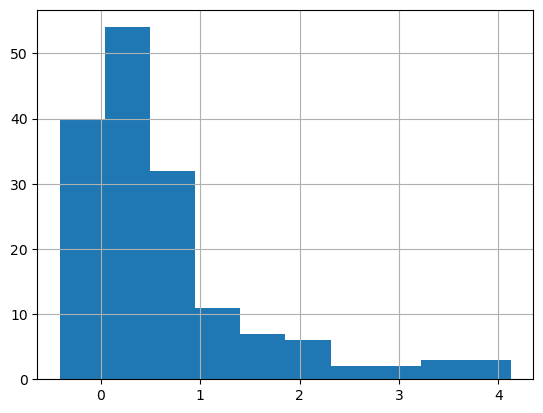

In [53]:
df["diff"].hist()

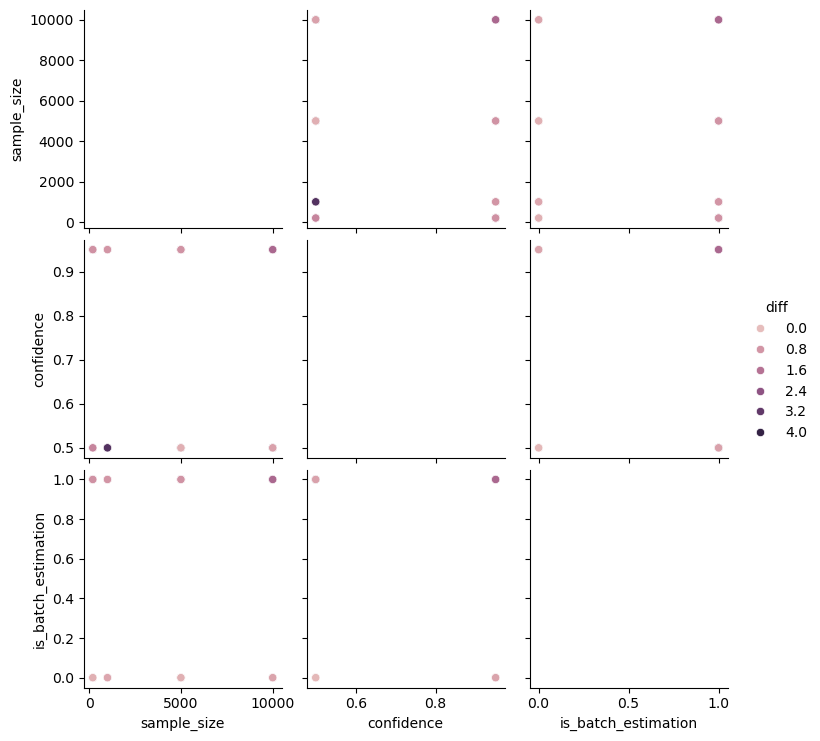

In [55]:
df = pd.DataFrame(experiment_results)
df["is_batch_estimation"] = df["cov_matrix_estimation_method"] == "batch"

sns.pairplot(
    df,
    x_vars=["sample_size", "confidence", "is_batch_estimation"],
    y_vars=["sample_size", "confidence", "is_batch_estimation"],
    hue="diff",
)

In [ ]:
z

In [27]:
hotelling_confidence = 0.95
sample_sizes = [200, 500, 1000, 5000, 10000]
# sample_sizes = [5000]
n_attempts = 10
for sample_size in sample_sizes:
    for i in range(n_attempts):
        print(f"Sample size: {sample_size}, Attempt: {i+1}/{n_attempts}")
        observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)

        sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        sample_features = mple_model._metrics_collection.calculate_sample_statistics(sample_from_mple)
        mean_features = np.mean(sample_features, axis=1)
        estimated_cov_matrix = covariance_matrix_estimation(sample_features, mean_features, method="naive")
        inv_estimated_cov_matrix = np.linalg.pinv(estimated_cov_matrix)

        convergence_tester = ConvergenceTester()

        hotelling_result = convergence_tester.hotelling(observed_features, 
                                                        mean_features, 
                                                        inv_estimated_cov_matrix, 
                                                        sample_size, 
                                                        hotelling_confidence)
        
        experiment_results.append({
            "test_type": "Hotelling",
            "sample_size": sample_size,
            "test_statistic": hotelling_result["statistic"],
            "test_critical_value": hotelling_result["threshold"],
            "diff": hotelling_result["statistic"] - hotelling_result["threshold"],
            "success": hotelling_result["success"],
            "confidence": hotelling_confidence,
            "cov_matrix_estimation_method": "naive",
        })




Sample size: 200, Attempt: 1/10
Sample size: 200, Attempt: 2/10
Sample size: 200, Attempt: 3/10
Sample size: 200, Attempt: 4/10
Sample size: 200, Attempt: 5/10
Sample size: 200, Attempt: 6/10
Sample size: 200, Attempt: 7/10
Sample size: 200, Attempt: 8/10
Sample size: 200, Attempt: 9/10
Sample size: 200, Attempt: 10/10
Sample size: 500, Attempt: 1/10
Sample size: 500, Attempt: 2/10
Sample size: 500, Attempt: 3/10
Sample size: 500, Attempt: 4/10
Sample size: 500, Attempt: 5/10
Sample size: 500, Attempt: 6/10
Sample size: 500, Attempt: 7/10
Sample size: 500, Attempt: 8/10
Sample size: 500, Attempt: 9/10
Sample size: 500, Attempt: 10/10
Sample size: 1000, Attempt: 1/10
Sample size: 1000, Attempt: 2/10
Sample size: 1000, Attempt: 3/10
Sample size: 1000, Attempt: 4/10
Sample size: 1000, Attempt: 5/10
Sample size: 1000, Attempt: 6/10
Sample size: 1000, Attempt: 7/10
Sample size: 1000, Attempt: 8/10
Sample size: 1000, Attempt: 9/10
Sample size: 1000, Attempt: 10/10
Sample size: 5000, Attempt:

In [18]:
hotelling_confidence = 0.5
sample_sizes = [200, 500, 1000, 5000, 10000]
# sample_sizes = [5000]
n_attempts = 10
for sample_size in sample_sizes:
    for i in range(n_attempts):
        print(f"Sample size: {sample_size}, Attempt: {i+1}/{n_attempts}")
        observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)

        sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        sample_features = mple_model._metrics_collection.calculate_sample_statistics(sample_from_mple)
        mean_features = np.mean(sample_features, axis=1)
        estimated_cov_matrix = covariance_matrix_estimation(sample_features, mean_features, method="naive")
        inv_estimated_cov_matrix = np.linalg.pinv(estimated_cov_matrix)

        convergence_tester = ConvergenceTester()

        hotelling_result = convergence_tester.hotelling(observed_features, 
                                                        mean_features, 
                                                        inv_estimated_cov_matrix, 
                                                        sample_size, 
                                                        hotelling_confidence)
        
        experiment_results.append({
            "test_type": "Hotelling",
            "sample_size": sample_size,
            "test_statistic": hotelling_result["statistic"],
            "test_critical_value": hotelling_result["threshold"],
            "diff": hotelling_result["statistic"] - hotelling_result["threshold"],
            "success": hotelling_result["success"],
            "confidence": hotelling_confidence
        })



Sample size: 200, Attempt: 1/10
Sample size: 200, Attempt: 2/10
Sample size: 200, Attempt: 3/10
Sample size: 200, Attempt: 4/10
Sample size: 200, Attempt: 5/10
Sample size: 200, Attempt: 6/10
Sample size: 200, Attempt: 7/10
Sample size: 200, Attempt: 8/10
Sample size: 200, Attempt: 9/10
Sample size: 200, Attempt: 10/10
Sample size: 500, Attempt: 1/10
Sample size: 500, Attempt: 2/10
Sample size: 500, Attempt: 3/10
Sample size: 500, Attempt: 4/10
Sample size: 500, Attempt: 5/10
Sample size: 500, Attempt: 6/10
Sample size: 500, Attempt: 7/10
Sample size: 500, Attempt: 8/10
Sample size: 500, Attempt: 9/10
Sample size: 500, Attempt: 10/10
Sample size: 1000, Attempt: 1/10
Sample size: 1000, Attempt: 2/10
Sample size: 1000, Attempt: 3/10
Sample size: 1000, Attempt: 4/10
Sample size: 1000, Attempt: 5/10
Sample size: 1000, Attempt: 6/10
Sample size: 1000, Attempt: 7/10
Sample size: 1000, Attempt: 8/10
Sample size: 1000, Attempt: 9/10
Sample size: 1000, Attempt: 10/10
Sample size: 5000, Attempt:

#### Network split augmentation

In [19]:
sample_sizes = [200, 500, 1000, 5000, 10000]
n_attempts = 10
# sample_sizes = [5000]
# n_attempts = 1

num_subsamples_from_observed = 1000 # Try also for [10, 100, 1k, 10k]
data_splitting_method = "uniform"

split_augmentation_features = mple_model._metrics_collection.bootstrap_observed_features(sampson_matrix,
                                                                num_subsamples=num_subsamples_from_observed,
                                                                splitting_method=data_splitting_method)
split_augment_observed_covariance = covariance_matrix_estimation(split_augmentation_features,
                                    split_augmentation_features.mean(axis=1), method='naive')
inv_split_augment_observed_covariance = np.linalg.inv(split_augment_observed_covariance)

num_subsamples = 100
subsample_size = 1000
confidence = 0.95
stds_away_thr = 1

for sample_size in sample_sizes:
    for i in range(n_attempts):
        print(f"Sample size: {sample_size}, Attempt: {i+1}/{n_attempts}")
        observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)

        sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        convergence_tester = ConvergenceTester()
    
        split_augmentation_result = convergence_tester.bootstrapped_mahalanobis_from_observed(
                    observed_features,
                    sample_from_mple,
                    mple_model._metrics_collection,
                    inv_split_augment_observed_covariance,
                    num_subsamples=num_subsamples,
                    subsample_size=subsample_size,
                    confidence=confidence,
                    stds_away_thr=stds_away_thr,
                )
        
        experiment_results.append({
            "sample_size": sample_size,
            "test_statistic": split_augmentation_result["statistic"],
            "test_critical_value": split_augmentation_result["threshold"],
            "diff": split_augmentation_result["statistic"] - split_augmentation_result["threshold"],
            "success": split_augmentation_result["success"],
            "test_type": "Split Augmentation with Bootstrapped Mahalanobis From Observed",
            "num_subsamples": num_subsamples,
            "subsample_size": subsample_size,
            "confidence": confidence,
            "stds_away_thr": stds_away_thr
        })



Sample size: 200, Attempt: 1/10
Sample size: 200, Attempt: 2/10
Sample size: 200, Attempt: 3/10
Sample size: 200, Attempt: 4/10
Sample size: 200, Attempt: 5/10
Sample size: 200, Attempt: 6/10
Sample size: 200, Attempt: 7/10
Sample size: 200, Attempt: 8/10
Sample size: 200, Attempt: 9/10
Sample size: 200, Attempt: 10/10
Sample size: 500, Attempt: 1/10
Sample size: 500, Attempt: 2/10
Sample size: 500, Attempt: 3/10
Sample size: 500, Attempt: 4/10
Sample size: 500, Attempt: 5/10
Sample size: 500, Attempt: 6/10
Sample size: 500, Attempt: 7/10
Sample size: 500, Attempt: 8/10
Sample size: 500, Attempt: 9/10
Sample size: 500, Attempt: 10/10
Sample size: 1000, Attempt: 1/10
Sample size: 1000, Attempt: 2/10
Sample size: 1000, Attempt: 3/10
Sample size: 1000, Attempt: 4/10
Sample size: 1000, Attempt: 5/10
Sample size: 1000, Attempt: 6/10
Sample size: 1000, Attempt: 7/10
Sample size: 1000, Attempt: 8/10
Sample size: 1000, Attempt: 9/10
Sample size: 1000, Attempt: 10/10
Sample size: 5000, Attempt:

### Bootstrapped mahalanobis from model

In [17]:
# bootstrapped_mahalanobis_from_model
experiment_results = []
sample_sizes = [200, 500, 1000, 5000]
n_attempts = 5
# sample_sizes = [5000]

# one_edge_neighbors_features = mple_model._metrics_collection.get_1_edge_neighboring_features(sampson_matrix)
# one_edge_neighbors_observed_covariance = covariance_matrix_estimation(one_edge_neighbors_features,
#                                     one_edge_neighbors_features.mean(axis=1), method='naive')
# inv_one_edge_neighbors_observed_covariance = np.linalg.inv(one_edge_neighbors_observed_covariance)

num_subsamples = 100
subsample_size = 1000
confidence = 0.95
stds_away_thr = 1

observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)

for sample_size in sample_sizes:
    for i in range(n_attempts):
        print(f"Sample size: {sample_size}, Attempt: {i+1}/{n_attempts}")
        

        # sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        # seed_network = mple_model.generate_networks_for_sample(sample_size=1, sampling_method="exact")[:, :, 0]
        # sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="metropolis_hastings", burn_in=0, seed_network=seed_network, mcmc_steps_per_sample=sampson_matrix.shape[0]**2)

        sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="metropolis_hastings", burn_in=0, mcmc_steps_per_sample=sampson_matrix.shape[0]**2)

        convergence_tester = ConvergenceTester()
    
        mahalanobis_from_model_test = convergence_tester.bootstrapped_mahalanobis_from_model(
                    observed_features,
                    sample_from_mple,
                    mple_model._metrics_collection,
                    num_subsamples=num_subsamples,
                    subsample_size=subsample_size,
                    confidence=confidence,
                    stds_away_thr=stds_away_thr,
                )
        
        experiment_results.append({
            "sample_size": sample_size,
            "test_statistic": mahalanobis_from_model_test["statistic"],
            "test_critical_value": mahalanobis_from_model_test["threshold"],
            "diff": mahalanobis_from_model_test["statistic"] - mahalanobis_from_model_test["threshold"],
            "success": mahalanobis_from_model_test["success"],
            "test_type": "Bootstrapped mahalanobis from model",
            "num_subsamples": num_subsamples,
            "subsample_size": subsample_size,
            "confidence": confidence,
            "stds_away_thr": stds_away_thr
        })



Sample size: 200, Attempt: 1/5
Sampled 100/200 networks, time taken: 0.40571022033691406
Sampled 200/200 networks, time taken: 0.8103659152984619
Sample size: 200, Attempt: 2/5
Sampled 100/200 networks, time taken: 0.37406110763549805
Sampled 200/200 networks, time taken: 0.7745420932769775
Sample size: 200, Attempt: 3/5
Sampled 100/200 networks, time taken: 0.4091928005218506
Sampled 200/200 networks, time taken: 0.791395902633667
Sample size: 200, Attempt: 4/5
Sampled 100/200 networks, time taken: 0.39715003967285156
Sampled 200/200 networks, time taken: 0.7863938808441162
Sample size: 200, Attempt: 5/5
Sampled 100/200 networks, time taken: 0.3864266872406006
Sampled 200/200 networks, time taken: 0.7885088920593262
Sample size: 500, Attempt: 1/5
Sampled 100/500 networks, time taken: 0.3980979919433594
Sampled 200/500 networks, time taken: 0.7904400825500488
Sampled 300/500 networks, time taken: 1.1814930438995361
Sampled 400/500 networks, time taken: 1.5820369720458984
Sampled 500/50

In [57]:


experiment_with_noisy_sample = []
sample_sizes = [200, 500, 1000, 5000]
n_attempts = 1
# sample_sizes = [5000]

# one_edge_neighbors_features = mple_model._metrics_collection.get_1_edge_neighboring_features(sampson_matrix)
# one_edge_neighbors_observed_covariance = covariance_matrix_estimation(one_edge_neighbors_features,
#                                     one_edge_neighbors_features.mean(axis=1), method='naive')
# inv_one_edge_neighbors_observed_covariance = np.linalg.inv(one_edge_neighbors_observed_covariance)

num_subsamples = 100
subsample_size = 1000
confidence = 0.95
stds_away_thr = 1

observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)


for sample_size in sample_sizes:
    for i in range(n_attempts):
        v1 = np.random.rand(observed_features.shape[0])
        v1 /= np.linalg.norm(v1)

        noise_observed_features = observed_features + 0.5 * v1

        
        print(f"Sample size: {sample_size}, Attempt: {i+1}/{n_attempts}")
        

        # sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        # seed_network = mple_model.generate_networks_for_sample(sample_size=1, sampling_method="exact")[:, :, 0]
        # sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="metropolis_hastings", burn_in=0, seed_network=seed_network, mcmc_steps_per_sample=sampson_matrix.shape[0]**2)

        # sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="metropolis_hastings", burn_in=0, mcmc_steps_per_sample=sampson_matrix.shape[0]**2)
        sampled_features_from_noise = np.random.multivariate_normal(noise_observed_features, np.eye(observed_features.shape[0]), size=sample_size).T

        # sample_size = sampled_networks.shape[2]
        num_of_features = observed_features.shape[0]

        mahalanobis_dists = np.zeros(num_subsamples)

        sub_sample_indices = np.random.choice(np.arange(sample_size), size=num_subsamples * subsample_size)
        sub_samples = sampled_features_from_noise[:, sub_sample_indices]
        # sub_samples_features = metrics_collection.calculate_sample_statistics(sub_samples)
        sub_samples_features = sub_samples.reshape(num_of_features, num_subsamples, subsample_size)

        for cur_subsam_idx in range(num_subsamples):
            sub_sample = sub_samples_features[:, cur_subsam_idx, :]
            sub_sample_mean = sub_sample.mean(axis=1)
            model_covariance_matrix = covariance_matrix_estimation(sub_sample, sub_sample_mean, method="naive")
            inv_model_cov_matrix = np.linalg.pinv(model_covariance_matrix)
            mahalanobis_dists[cur_subsam_idx] = mahalanobis(observed_features, sub_sample_mean, inv_model_cov_matrix)
        
        empirical_threshold = np.quantile(mahalanobis_dists, confidence)

        # return {
        #     "success": empirical_threshold < stds_away_thr,
        #     "statistic": empirical_threshold,
        #     "threshold": stds_away_thr
        # }

        # convergence_tester = ConvergenceTester()
    
        # mahalanobis_from_model_test = convergence_tester.bootstrapped_mahalanobis_from_model(
        #             observed_features,
        #             sample_from_noise,
        #             mple_model._metrics_collection,
        #             num_subsamples=num_subsamples,
        #             subsample_size=subsample_size,
        #             confidence=confidence,
        #             stds_away_thr=stds_away_thr,
        #         )
        
        experiment_with_noisy_sample.append({
            "sample_size": sample_size,
            "test_statistic": empirical_threshold,
            "test_critical_value": stds_away_thr,
            "diff": empirical_threshold - stds_away_thr,
            # "success": mahalanobis_from_model_test["success"],
            "test_type": "Bootstrapped mahalanobis from noisy model",
            "num_subsamples": num_subsamples,
            "subsample_size": subsample_size,
            "confidence": confidence,
            "stds_away_thr": stds_away_thr
        })



Sample size: 200, Attempt: 1/1
Sample size: 500, Attempt: 1/1
Sample size: 1000, Attempt: 1/1
Sample size: 5000, Attempt: 1/1


<Axes: xlabel='sample_size', ylabel='diff'>

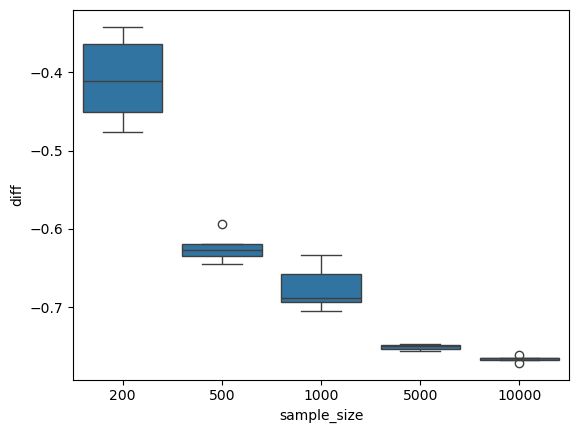

In [10]:
experiments_df = pd.DataFrame(experiment_results)
sns.boxplot(
    x="sample_size", 
    y="diff", 
    data=experiments_df, 
)

### 1-edge noisy neighborhood

In [20]:
sample_sizes = [200, 500, 1000, 5000, 10000]
n_attempts = 10
# sample_sizes = [5000]

one_edge_neighbors_features = mple_model._metrics_collection.get_1_edge_neighboring_features(sampson_matrix)
one_edge_neighbors_observed_covariance = covariance_matrix_estimation(one_edge_neighbors_features,
                                    one_edge_neighbors_features.mean(axis=1), method='naive')
inv_one_edge_neighbors_observed_covariance = np.linalg.inv(one_edge_neighbors_observed_covariance)

num_subsamples = 100
subsample_size = 1000
confidence = 0.95
stds_away_thr = 1

for sample_size in sample_sizes:
    for i in range(n_attempts):
        print(f"Sample size: {sample_size}, Attempt: {i+1}/{n_attempts}")
        observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)

        sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        convergence_tester = ConvergenceTester()
    
        one_edge_neighbors_result = convergence_tester.bootstrapped_mahalanobis_from_observed(
                    observed_features,
                    sample_from_mple,
                    mple_model._metrics_collection,
                    inv_one_edge_neighbors_observed_covariance,
                    num_subsamples=num_subsamples,
                    subsample_size=subsample_size,
                    confidence=confidence,
                    stds_away_thr=stds_away_thr,
                )
        
        experiment_results.append({
            "sample_size": sample_size,
            "test_statistic": one_edge_neighbors_result["statistic"],
            "test_critical_value": one_edge_neighbors_result["threshold"],
            "diff": one_edge_neighbors_result["statistic"] - one_edge_neighbors_result["threshold"],
            "success": one_edge_neighbors_result["success"],
            "test_type": "1-edge neighbors with Bootstrapped Mahalanobis From Observed",
            "num_subsamples": num_subsamples,
            "subsample_size": subsample_size,
            "confidence": confidence,
            "stds_away_thr": stds_away_thr
        })



Sample size: 200, Attempt: 1/10
Sample size: 200, Attempt: 2/10
Sample size: 200, Attempt: 3/10
Sample size: 200, Attempt: 4/10
Sample size: 200, Attempt: 5/10
Sample size: 200, Attempt: 6/10
Sample size: 200, Attempt: 7/10
Sample size: 200, Attempt: 8/10
Sample size: 200, Attempt: 9/10
Sample size: 200, Attempt: 10/10
Sample size: 500, Attempt: 1/10
Sample size: 500, Attempt: 2/10
Sample size: 500, Attempt: 3/10
Sample size: 500, Attempt: 4/10
Sample size: 500, Attempt: 5/10
Sample size: 500, Attempt: 6/10
Sample size: 500, Attempt: 7/10
Sample size: 500, Attempt: 8/10
Sample size: 500, Attempt: 9/10
Sample size: 500, Attempt: 10/10
Sample size: 1000, Attempt: 1/10
Sample size: 1000, Attempt: 2/10
Sample size: 1000, Attempt: 3/10
Sample size: 1000, Attempt: 4/10
Sample size: 1000, Attempt: 5/10
Sample size: 1000, Attempt: 6/10
Sample size: 1000, Attempt: 7/10
Sample size: 1000, Attempt: 8/10
Sample size: 1000, Attempt: 9/10
Sample size: 1000, Attempt: 10/10
Sample size: 5000, Attempt:

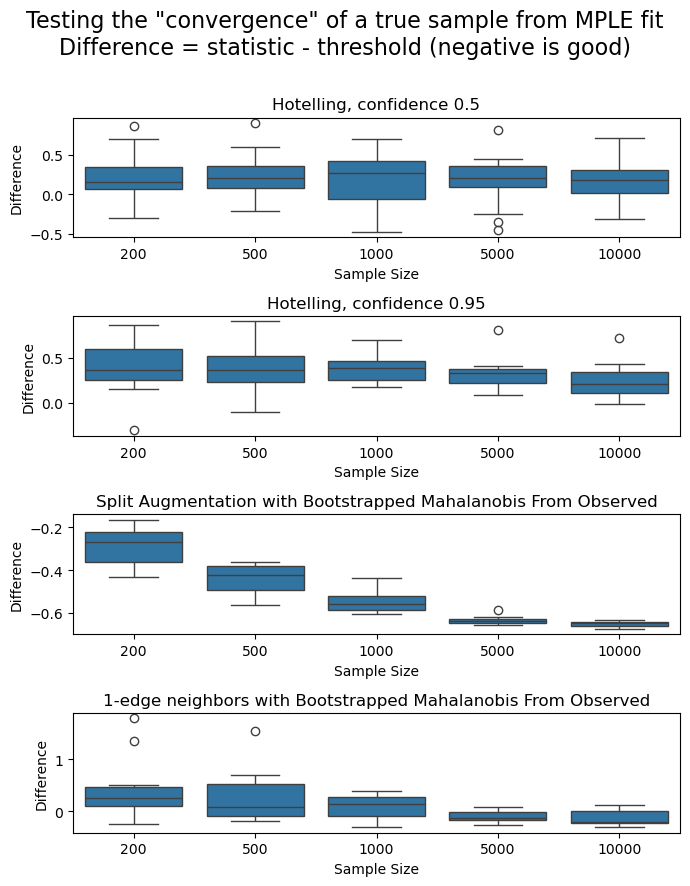

In [33]:
experiments_df = pd.DataFrame(experiment_results)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7, 9))

hotelling_df = experiments_df[experiments_df["test_type"] == "Hotelling"]
split_augmentation_df = experiments_df[experiments_df["test_type"] == "Split Augmentation with Bootstrapped Mahalanobis From Observed"]
one_edge_df = experiments_df[experiments_df["test_type"] == "1-edge neighbors with Bootstrapped Mahalanobis From Observed"]
hotelling_df_95 = experiments_df[(experiments_df["test_type"] == "Hotelling") & (experiments_df["confidence"] == 0.95)]

sns.boxplot(
    x="sample_size", 
    y="diff", 
    data=hotelling_df, 
    ax=ax[0])

sns.boxplot(
    x="sample_size", 
    y="diff", 
    data=hotelling_df_95, 
    ax=ax[1])

sns.boxplot(
    x="sample_size", 
    y="diff", 
    data=split_augmentation_df, 
    ax=ax[2])

sns.boxplot(
    x="sample_size", 
    y="diff", 
    data=one_edge_df, 
    ax=ax[3])

ax[0].set_title(f"Hotelling, confidence 0.5")
ax[1].set_title(f"Hotelling, confidence 0.95")
ax[2].set_title("Split Augmentation with Bootstrapped Mahalanobis From Observed")
ax[3].set_title("1-edge neighbors with Bootstrapped Mahalanobis From Observed")

ax[0].set_xlabel("Sample Size")
ax[1].set_xlabel("Sample Size")
ax[2].set_xlabel("Sample Size")
ax[3].set_xlabel("Sample Size")

ax[0].set_ylabel("Difference")
ax[1].set_ylabel("Difference")
ax[2].set_ylabel("Difference")
ax[3].set_ylabel("Difference")


suptitle = """Testing the "convergence" of a true sample from MPLE fit
Difference = statistic - threshold (negative is good)
"""

fig.suptitle(suptitle, fontsize=16)

plt.tight_layout()
plt.show()

# Test #2 - MCMLE fit

In [4]:
true_values = {"edges": -1.1761, "sender2": -0.2945, "sender3": 1.4141, "sender4": 0.3662, "sender5": 0.1315,
               "sender6": 1.2148, "sender7": 0.6055,
               "sender8": 1.3609, "sender9": 0.6402, "sender10": 2.0639, "sender11": 1.4355, "sender12": -0.1681,
               "sender13": -0.2322, "sender14": 0.5841, "sender15": 1.8600,
               "sender16": 1.4317, "sender17": 1.2211, "sender18": 1.8724, "receiver2": -0.1522, "receiver3": -3.0453,
               "receiver4": -1.7596, "receiver5": -0.8198, "receiver6": -3.3922,
               "receiver7": -1.6074, "receiver8": -2.2656, "receiver9": -2.2069, "receiver10": -3.9189,
               "receiver11": -3.0257, "receiver12": -0.9457, "receiver13": -1.4749, "receiver14": -1.5950,
               "receiver15": -3.3147, "receiver16": -3.0567, "receiver17": -3.4436, "receiver18": -3.3239,
               "mutual": 3.6918
               }

true_thetas = np.array(list(true_values.values()))

In [20]:
metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree(), TotalReciprocity()]

n_nodes = sampson_matrix.shape[0]

sample_sizes = [200, 500, 1000, 5000]

num_attempts = 10

num_subsamples = [5, 20, 50, 100]
subsample_size = [100, 1000]
confidence = [0.95, 0.99]
stds_away_thr = [0.1, 0.5, 1]
mcmc_steps_per_sample = [n_nodes, n_nodes**2]
mcmc_burn_in = [0, 5000, 10000]
mcmle_experiments = []

# for sample_size in sample_sizes:
#   for i in range(num_attempts):
#     print(f"Sample size: {sample_size}, Attempt: {i+1}/{num_attempts}")  
#     mcmle_model = ERGM(n_nodes, metrics, is_directed=True)
        
#     grads, convergence_result = mcmle_model.fit(sampson_matrix, 
#             opt_steps=5, steps_for_decay=1, lr=0.5, mple_lr=0.5, 
#             convergence_criterion="model_bootstrap",
#               mcmc_burn_in=10000,
#               mcmc_steps_per_sample=n_nodes**2,
#               mcmc_sample_size=sample_size,
#               num_model_sub_samples=num_subsamples,
#               model_subsample_size=subsample_size,
#               bootstrap_convergence_confidence=confidence,
#               bootstrap_convergence_num_stds_away_thr=stds_away_thr
#               )
    
#     model_thethas = mcmle_model._thetas

#     mcmle_experiments.append({
#               "sample_size": sample_size,
#               "test_statistic": convergence_result["statistic"],
#               "test_critical_value": convergence_result["threshold"],
#               "diff": convergence_result["statistic"] - convergence_result["threshold"],
#               "success": convergence_result["success"],
#               "test_type": "MCMLE with model bootstrap",
#               "num_subsamples": num_subsamples,
#               "subsample_size": subsample_size,
#               "confidence": confidence,
#               "stds_away_thr": stds_away_thr,
#               "MSE_with_true_thetas": np.mean((model_thethas - true_thetas)**2),
#               "R^2": 1 - np.sum((model_thethas - true_thetas)**2) / np.sum((true_thetas - np.mean(true_thetas))**2),
#               "pearsonr": pearsonr(model_thethas, true_thetas)[0]**2,
#               "steps_until_convergence": grads.shape[0]
#           })


    




Sample size: 200, Attempt: 1/5
Removing the 0 feature of outdegree to fix multi-collinearity
Removing the 0 feature of indegree to fix multi-collinearity
MPLE with lr 0.5
Logistic regression optimization started
Iteration 0, log-likelihood: -345.7956548229145, time from start: 0.05273812497034669 seconds, lr: 0.5
Iteration 1, log-likelihood: -152.89432400446546, time from start: 0.15519512491300702 seconds, lr: 0.5
Iteration 2, log-likelihood: -131.76655184122393, time from start: 0.2262860839255154 seconds, lr: 0.5
Iteration 3, log-likelihood: -122.42742041608291, time from start: 0.2963311248458922 seconds, lr: 0.5
Iteration 4, log-likelihood: -118.24774573410988, time from start: 0.32774183386936784 seconds, lr: 0.5
Iteration 5, log-likelihood: -116.51408588638968, time from start: 0.38839004188776016 seconds, lr: 0.5
Iteration 6, log-likelihood: -115.87397994180807, time from start: 0.4089089999906719 seconds, lr: 0.5
Iteration 7, log-likelihood: -115.66475726658277, time from star

In [21]:
df = pd.DataFrame(mcmle_experiments)
df.head()

,sample_size,test_statistic,test_critical_value,diff,success,test_type,num_subsamples,subsample_size,confidence,stds_away_thr,MSE_with_true_thetas,R^2,pearsonr,steps_until_convergence
0,200,1.091629,1,0.091629,False,MCMLE with model bootstrap,100,1000,0.95,1,0.004041,0.998934,0.999140,5
1,200,0.827090,1,-0.172910,True,MCMLE with model bootstrap,100,1000,0.95,1,0.004417,0.998835,0.999167,4
2,200,0.870928,1,-0.129072,True,MCMLE with model bootstrap,100,1000,0.95,1,0.006206,0.998363,0.999130,3
3,200,0.869415,1,-0.130585,True,MCMLE with model bootstrap,100,1000,0.95,1,0.009214,0.997570,0.998967,4
4,200,0.904354,1,-0.095646,True,MCMLE with model bootstrap,100,1000,0.95,1,0.003132,0.999174,0.999437,3


<Axes: xlabel='diff', ylabel='MSE_with_true_thetas'>

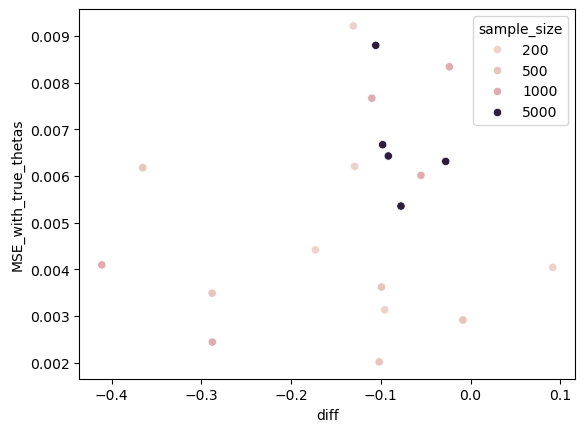

In [22]:
sns.scatterplot(data=df, x="diff", y="MSE_with_true_thetas", hue="sample_size")

<Axes: xlabel='sample_size', ylabel='steps_until_convergence'>

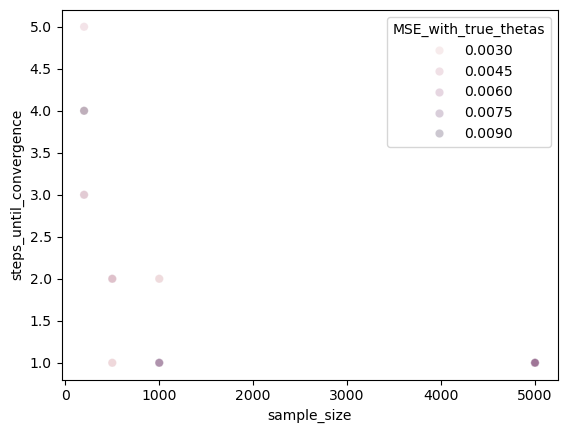

In [28]:
sns.scatterplot(data=df, x="sample_size", y="steps_until_convergence", alpha=0.25, hue="MSE_with_true_thetas")

### Goal
Find a theoretical bound for the distance between $g(y_\text{obs})$ and the mean of a model sample.

Formally - Define $X$ to be a random variable - 
$$
X = \frac{1}{m}\sum_{i=1}^m g(y_i)  
\\
y_i \sim \text{ERGM}(\theta)
\ ,  \ 
\Pr(y_i) = \frac{1}{Z}\exp(\theta^T g(y))
$$


Now we can use the **Chernoff bound** - 
$$
\forall t > 0 : Pr [ X \geq (1+\delta) g(y_\text{obs}) ] \leq \frac{\mathbb{E}[e^{tX}]}{e^{tc}}
$$

where $\mathbb{E}[e^{tX}]$ is the **Moment Generating Function**. 



If we can express $\mathbb{E}[e^{tX}]$ in terms $m$ (sample size) and $q$ (Feature vector dimension), and we set $\delta = \frac{1}{10}$ or whatever, then we can calculate a bound...



$d(y_i) =  || (\frac{1}{m} \sum_{j \in [m]} g(y_j)) - g(y_i) ||_2 $



And then do `np.quantile` on - $\{d_{y_\text{obs}} , d(y_1,) ... , d(y_m\}$

# Experiments from cluster

In [24]:
import glob
path = "/Volumes/tomta/pyERGM/benchmarking_results/6k_first_test"

all_files = glob.glob(path + "/*.pkl")

all_results = []

for i, filename in enumerate(all_files):
    with open(filename, "rb") as f:
        results = pickle.load(f)
        all_results.extend(results)
    
    print(f"Read data for file #{i+1}/{len(all_files)}")
    

In [4]:
df = pd.DataFrame(all_results)
df["text_critical_value"] = df["test_critical_value"].apply(lambda x: x[0])
df["diff"] = df["diff"].apply(lambda x: x[0])
df["success"] = df["success"].apply(lambda x: x[0])
df["MSE_with_true_thetas"] = df["MSE_with_true_thetas"].apply(lambda x: x[0])
df["R^2"] = df["R^2"].apply(lambda x: x[0])
df["pearsonr"] = df["pearsonr"].apply(lambda x: x[0])

with open("benchmarks_6k_df.pkl", "wb") as f:
    pickle.dump(df, f)

In [36]:
df

,confidence,cov_matrix_estimation_method,sample_size,num_attempts,num_subsamples,subsample_size,stds_away_thr,mcmc_steps_per_sample,mcmc_burn_in,with_mple,...,max_iter_steps,test_statistic,test_critical_value,diff,success,MSE_with_true_thetas,R^2,pearsonr,completed_steps,text_critical_value
0,0.50,naive,1000,10,100,1000,0.5,18,20000,False,...,20,15.517907,"(1,)",14.517907,False,3.141331,0.171489,0.284100,20,1
1,0.50,naive,1000,10,100,1000,0.5,18,20000,False,...,20,13.658631,"(1,)",12.658631,False,2.782347,0.266169,0.457916,20,1
2,0.50,naive,1000,10,100,1000,0.5,18,20000,False,...,20,9.309386,"(1,)",8.309386,False,3.236885,0.146287,0.188784,20,1
3,0.50,naive,1000,10,100,1000,0.5,18,20000,False,...,20,9.973018,"(1,)",8.973018,False,2.744297,0.276205,0.453450,20,1
4,0.50,naive,1000,10,100,1000,0.5,18,20000,False,...,20,13.987937,"(1,)",12.987937,False,3.625530,0.043783,0.079141,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37557,0.95,naive,1000,10,10,1000,0.5,324,20000,False,...,20,0.785740,"(1,)",-0.214260,True,0.010203,0.997309,0.999587,5,1
37558,0.95,naive,1000,10,10,1000,0.5,324,20000,False,...,20,0.723645,"(1,)",-0.276355,True,0.008930,0.997645,0.999684,5,1
37559,0.95,naive,1000,10,10,1000,0.5,324,20000,False,...,20,0.783916,"(1,)",-0.216084,True,0.006329,0.998331,0.999544,6,1
37560,0.95,naive,1000,10,10,1000,0.5,324,20000,False,...,20,0.747875,"(1,)",-0.252125,True,0.005041,0.998671,0.999597,6,1


In [39]:
df["stds_away_thr"].unique()

array([0.5, 1. ])

In [49]:
means

mcmc_burn_in,0,20000
mcmc_steps_per_sample,,
324,0.996700,0.996684
1000,0.996926,0.996838


/var/folders/sc/j_2lnrh51j14gx7ybzvzdk1w0000gn/T/ipykernel_45514/4216310618.py:13: FutureWarning: The provided callable <function mean at 0x105ed23e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  means = df_for_heatmaps.pivot_table(index=feature1, columns=feature2, values="R^2", aggfunc=np.mean)
/var/folders/sc/j_2lnrh51j14gx7ybzvzdk1w0000gn/T/ipykernel_45514/4216310618.py:14: FutureWarning: The provided callable <function std at 0x105ed25c0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  std = df_for_heatmaps.pivot_table(index=feature1, columns=feature2, values="R^2", aggfunc=np.std)
/var/folders/sc/j_2lnrh51j14gx7ybzvzdk1w0000gn/T/ipykernel_45514/4216310618.py:13: FutureWarning: The provided callable <function mean at 0x105ed23e

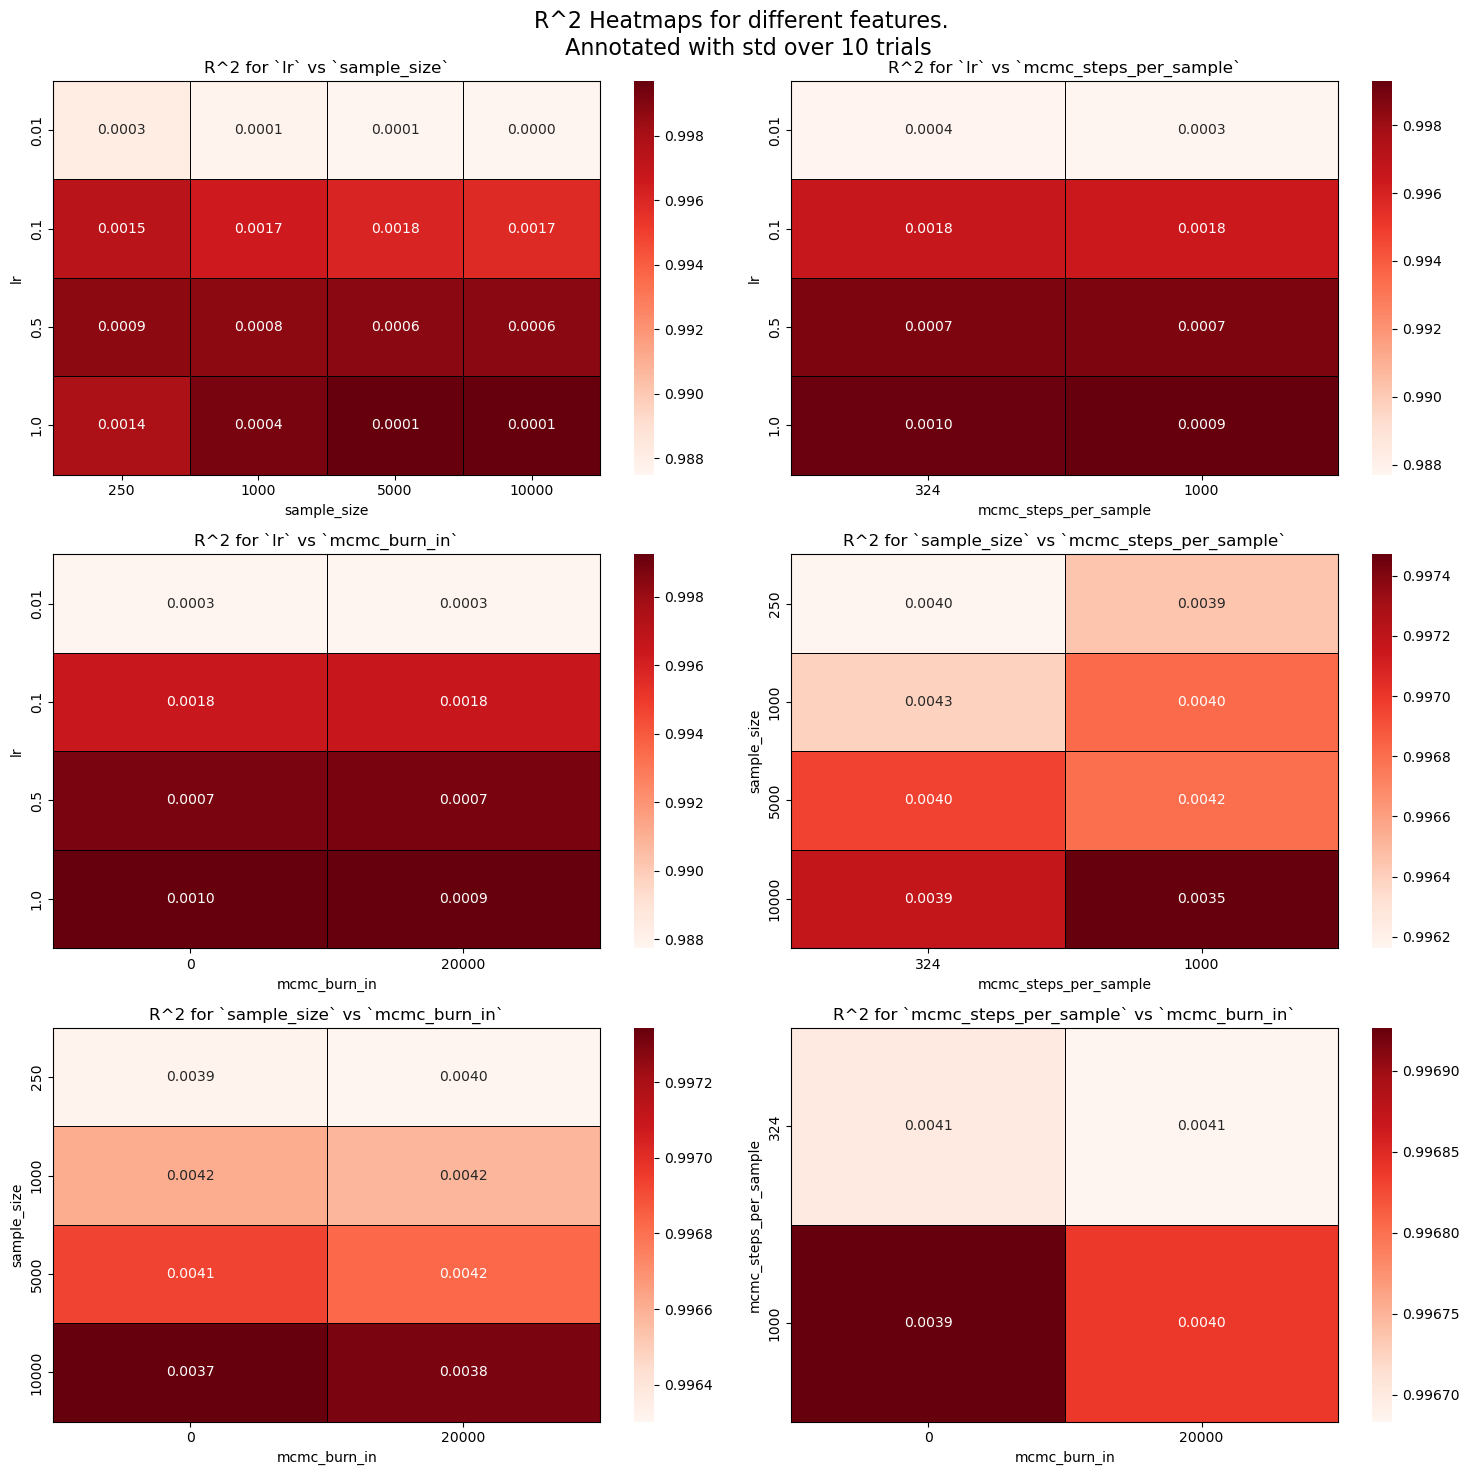

In [53]:
features_for_comparison = ["lr", "sample_size", "mcmc_steps_per_sample", "mcmc_burn_in"]
df_for_heatmaps = df[(df["with_mple"] == True) & (df["mcmc_steps_per_sample"] > 18)]

feature_pairs = list(itertools.combinations(features_for_comparison, 2))
nrows = len(feature_pairs) // 2
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

for i, feature_pair in enumerate(feature_pairs):
    feature1, feature2 = feature_pair

    means = df_for_heatmaps.pivot_table(index=feature1, columns=feature2, values="R^2", aggfunc=np.mean)
    std = df_for_heatmaps.pivot_table(index=feature1, columns=feature2, values="R^2", aggfunc=np.std)

    sns.heatmap(
        means, 
        ax=ax[i//2, i%2], 
        cmap="Reds", 
        linecolor="black", 
        linewidth=0.5, 
        annot=std, 
        fmt=".4f"
    )
    ax[i//2, i%2].set_title(f"R^2 for `{feature1}` vs `{feature2}`") 
    ax[i//2, i%2].spines["top"].set_visible(True)
    ax[i//2, i%2].spines["bottom"].set_visible(True)
    ax[i//2, i%2].spines["left"].set_visible(True)
    ax[i//2, i%2].spines["right"].set_visible(True)

fig.suptitle("R^2 Heatmaps for different features. \n Annotated with std over 10 trials", fontsize=16)

plt.tight_layout()
plt.show()

/var/folders/sc/j_2lnrh51j14gx7ybzvzdk1w0000gn/T/ipykernel_45514/2411429084.py:13: FutureWarning: The provided callable <function mean at 0x105ed23e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  means = df_for_heatmaps.pivot_table(index=feature1, columns=feature2, values="MSE_with_true_thetas", aggfunc=np.mean)
/var/folders/sc/j_2lnrh51j14gx7ybzvzdk1w0000gn/T/ipykernel_45514/2411429084.py:14: FutureWarning: The provided callable <function std at 0x105ed25c0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  std = df_for_heatmaps.pivot_table(index=feature1, columns=feature2, values="MSE_with_true_thetas", aggfunc=np.std)
/var/folders/sc/j_2lnrh51j14gx7ybzvzdk1w0000gn/T/ipykernel_45514/2411429084.py:13: FutureWarning: The provided cal

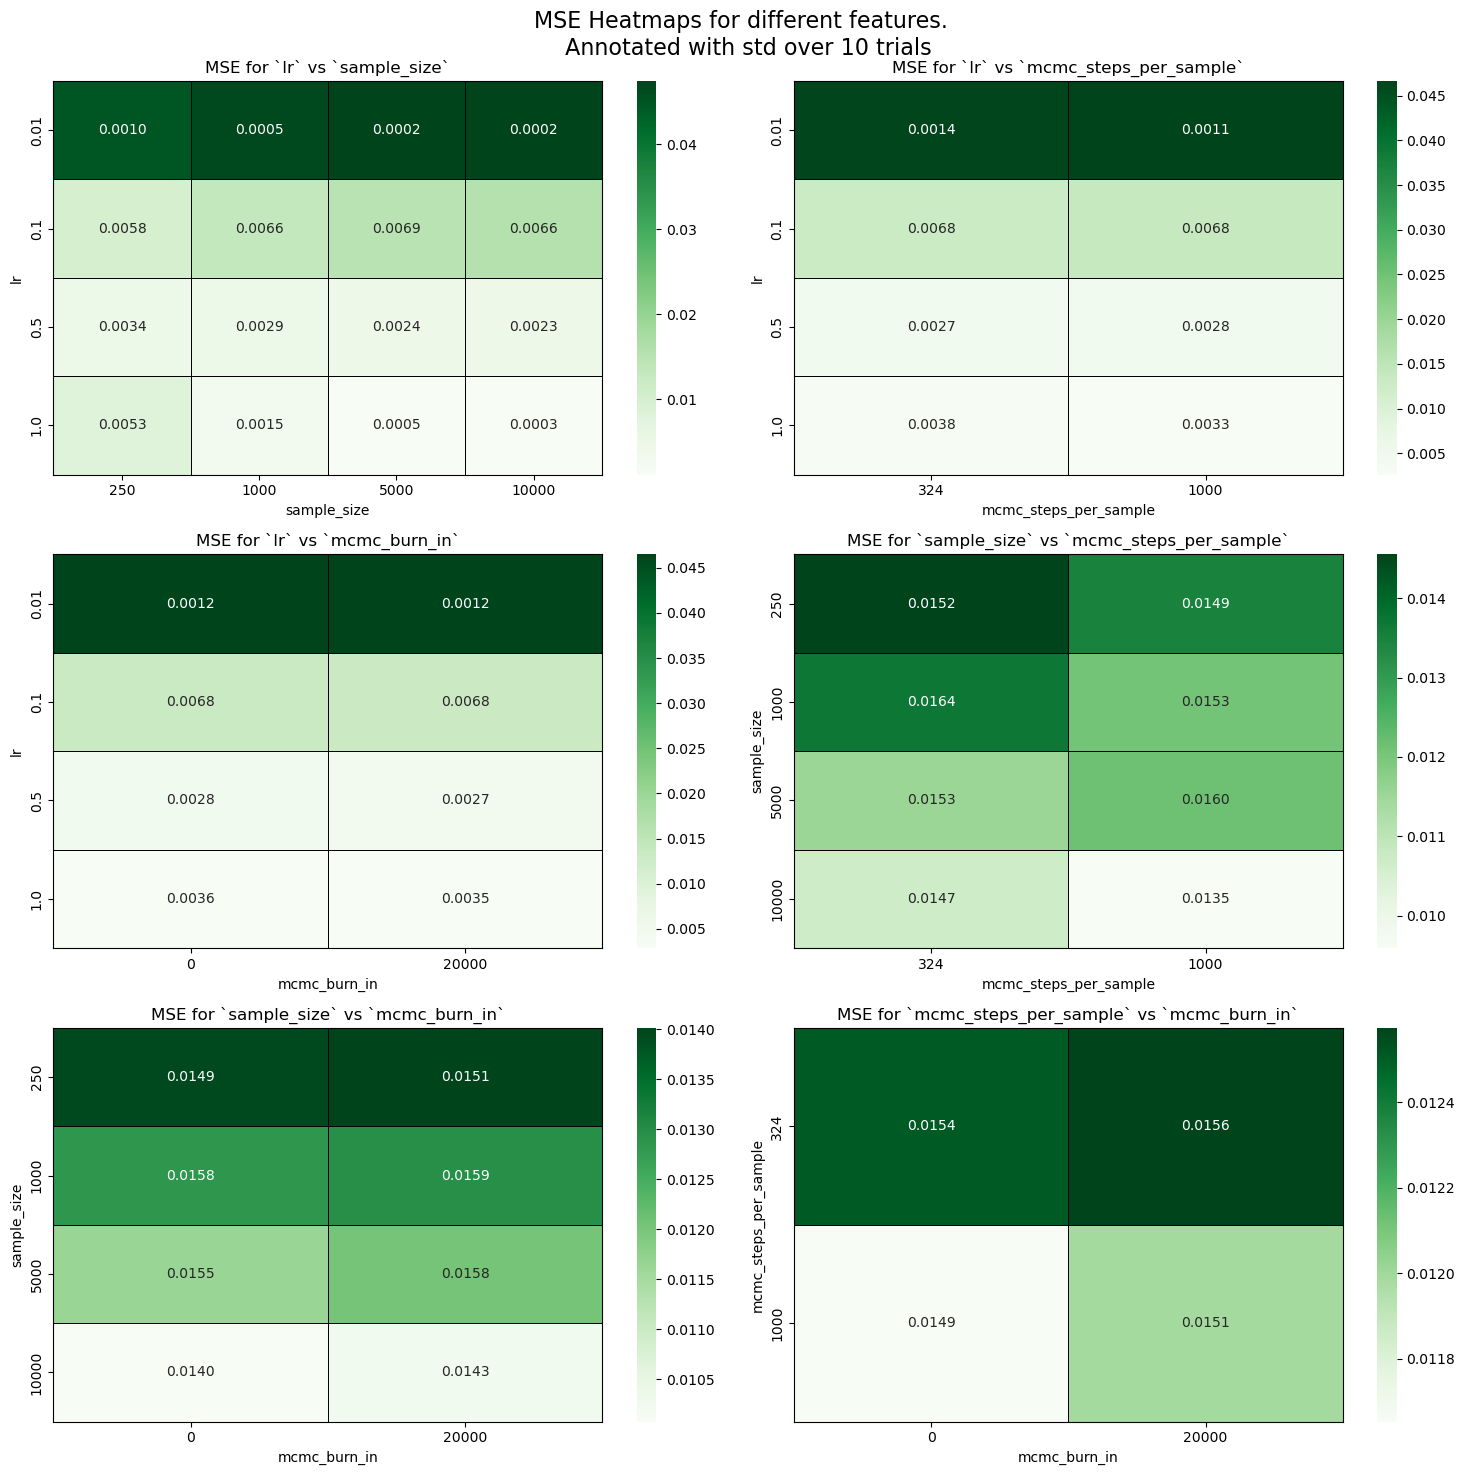

In [55]:
features_for_comparison = ["lr", "sample_size", "mcmc_steps_per_sample", "mcmc_burn_in"]
df_for_heatmaps = df[(df["with_mple"] == True) & (df["mcmc_steps_per_sample"] > 18)]

feature_pairs = list(itertools.combinations(features_for_comparison, 2))
nrows = len(feature_pairs) // 2
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

for i, feature_pair in enumerate(feature_pairs):
    feature1, feature2 = feature_pair

    means = df_for_heatmaps.pivot_table(index=feature1, columns=feature2, values="MSE_with_true_thetas", aggfunc=np.mean)
    std = df_for_heatmaps.pivot_table(index=feature1, columns=feature2, values="MSE_with_true_thetas", aggfunc=np.std)

    sns.heatmap(
        means, 
        ax=ax[i//2, i%2], 
        cmap="Greens", 
        linecolor="black", 
        linewidth=0.5, 
        annot=std, 
        fmt=".4f"
    )
    ax[i//2, i%2].set_title(f"MSE for `{feature1}` vs `{feature2}`") 
    ax[i//2, i%2].spines["top"].set_visible(True)
    ax[i//2, i%2].spines["bottom"].set_visible(True)
    ax[i//2, i%2].spines["left"].set_visible(True)
    ax[i//2, i%2].spines["right"].set_visible(True)

fig.suptitle("MSE Heatmaps for different features. \n Annotated with std over 10 trials", fontsize=16)

plt.tight_layout()
plt.show()

/var/folders/sc/j_2lnrh51j14gx7ybzvzdk1w0000gn/T/ipykernel_45514/4050046256.py:13: FutureWarning: The provided callable <function mean at 0x105ed23e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  means = df_for_heatmaps.pivot_table(index=feature1, columns=feature2, values="pearsonr", aggfunc=np.mean)
/var/folders/sc/j_2lnrh51j14gx7ybzvzdk1w0000gn/T/ipykernel_45514/4050046256.py:14: FutureWarning: The provided callable <function std at 0x105ed25c0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  std = df_for_heatmaps.pivot_table(index=feature1, columns=feature2, values="pearsonr", aggfunc=np.std)
/var/folders/sc/j_2lnrh51j14gx7ybzvzdk1w0000gn/T/ipykernel_45514/4050046256.py:13: FutureWarning: The provided callable <function mean at 

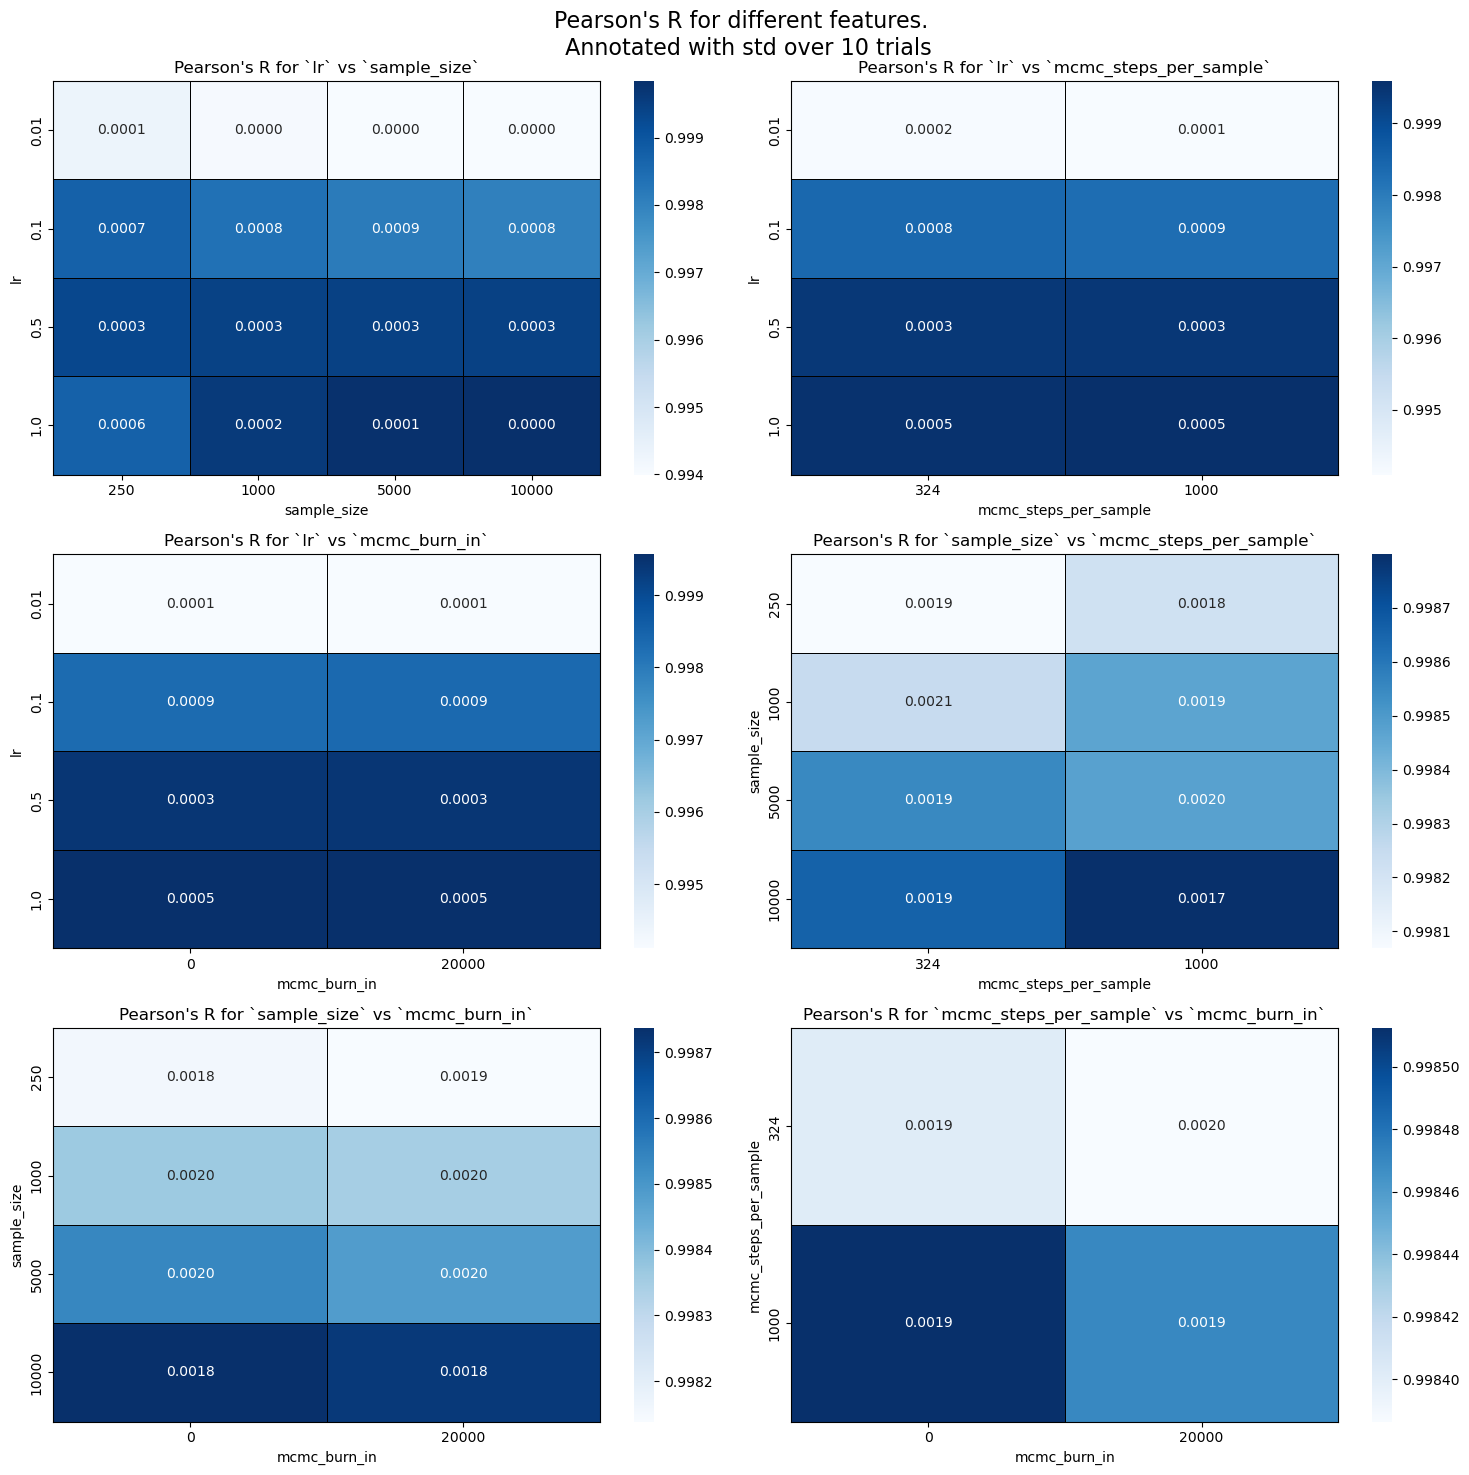

In [57]:
features_for_comparison = ["lr", "sample_size", "mcmc_steps_per_sample", "mcmc_burn_in"]
df_for_heatmaps = df[(df["with_mple"] == True) & (df["mcmc_steps_per_sample"] > 18)]

feature_pairs = list(itertools.combinations(features_for_comparison, 2))
nrows = len(feature_pairs) // 2
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

for i, feature_pair in enumerate(feature_pairs):
    feature1, feature2 = feature_pair

    means = df_for_heatmaps.pivot_table(index=feature1, columns=feature2, values="pearsonr", aggfunc=np.mean)
    std = df_for_heatmaps.pivot_table(index=feature1, columns=feature2, values="pearsonr", aggfunc=np.std)

    sns.heatmap(
        means, 
        ax=ax[i//2, i%2], 
        cmap="Blues", 
        linecolor="black", 
        linewidth=0.5, 
        annot=std, 
        fmt=".4f"
    )
    ax[i//2, i%2].set_title(f"Pearson's R for `{feature1}` vs `{feature2}`") 
    ax[i//2, i%2].spines["top"].set_visible(True)
    ax[i//2, i%2].spines["bottom"].set_visible(True)
    ax[i//2, i%2].spines["left"].set_visible(True)
    ax[i//2, i%2].spines["right"].set_visible(True)

fig.suptitle("Pearson's R for different features. \n Annotated with std over 10 trials", fontsize=16)

plt.tight_layout()
plt.show()

In [59]:
df[features_for_comparison]

,lr,sample_size,mcmc_steps_per_sample,mcmc_burn_in
0,0.01,1000,18,20000
1,0.01,1000,18,20000
2,0.01,1000,18,20000
3,0.01,1000,18,20000
4,0.01,1000,18,20000
...,...,...,...,...
37557,0.50,1000,324,20000
37558,0.50,1000,324,20000
37559,0.50,1000,324,20000
37560,0.50,1000,324,20000


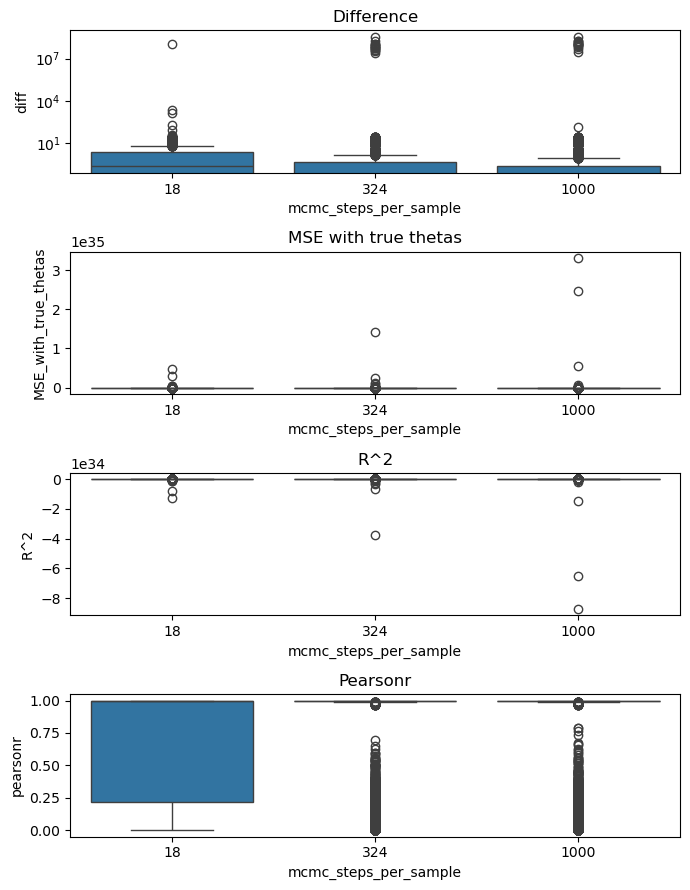

In [17]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7, 9))
sns.boxplot(data=df[df["mcmc_steps_per_sample"]], x="mcmc_steps_per_sample", y="diff", ax=ax[0])

sns.boxplot(data=df[df["mcmc_steps_per_sample"]], x="mcmc_steps_per_sample", y="MSE_with_true_thetas", ax=ax[1])

sns.boxplot(data=df[df["mcmc_steps_per_sample"]], x="mcmc_steps_per_sample", y="R^2", ax=ax[2])

sns.boxplot(data=df[df["mcmc_steps_per_sample"]], x="mcmc_steps_per_sample", y="pearsonr", ax=ax[3])

ax[0].set_title("Difference")
ax[1].set_title("MSE with true thetas")
ax[2].set_title("R^2")
ax[3].set_title("Pearsonr")

ax[0].set_yscale("log")

plt.tight_layout()
plt.show()

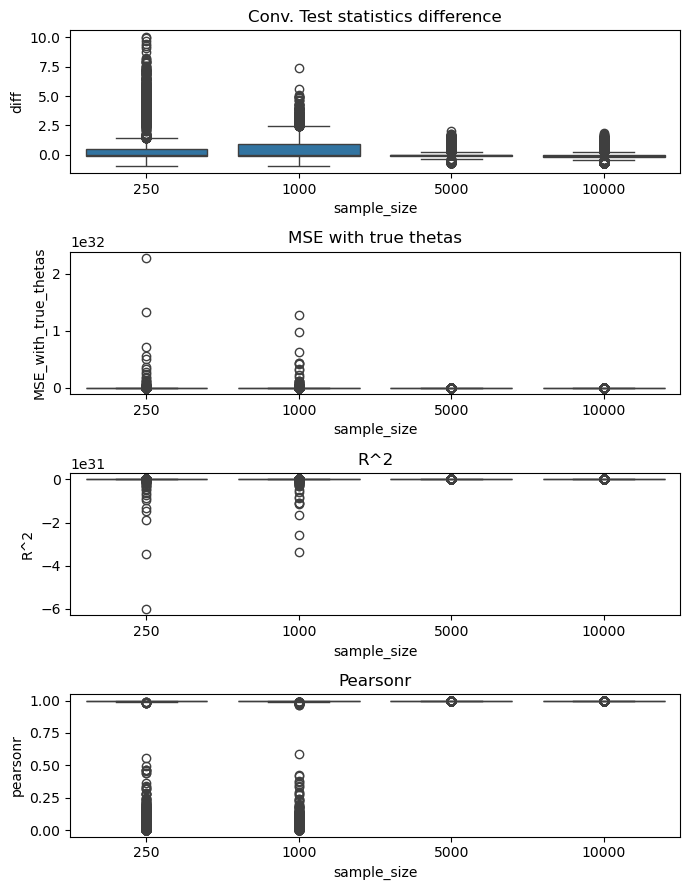

In [34]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7, 9))

df_to_show = df[(df["mcmc_steps_per_sample"] >= 18) & (df["with_mple"] == True)]
# df_to_show = df[(df["mcmc_steps_per_sample"] > 18)]
# df_to_show = df[(df["with_mple"] == True)]

sns.boxplot(data=df_to_show, x="sample_size", y="diff", ax=ax[0])

sns.boxplot(data=df_to_show, x="sample_size", y="MSE_with_true_thetas", ax=ax[1])

sns.boxplot(data=df_to_show, x="sample_size", y="R^2", ax=ax[2])

sns.boxplot(data=df_to_show, x="sample_size", y="pearsonr", ax=ax[3])

ax[0].set_title("Conv. Test statistics difference")
ax[1].set_title("MSE with true thetas")
ax[2].set_title("R^2")
ax[3].set_title("Pearsonr")

# ax[0].set_yscale("log")


plt.tight_layout()
plt.show()

In [21]:
df[(df["mcmc_steps_per_sample"] > 18) & (df["with_mple"] == True)].sort_values("MSE_with_true_thetas", ascending=False).head(10)

,confidence,cov_matrix_estimation_method,sample_size,num_attempts,num_subsamples,subsample_size,stds_away_thr,mcmc_steps_per_sample,mcmc_burn_in,with_mple,...,max_iter_steps,test_statistic,test_critical_value,diff,success,MSE_with_true_thetas,R^2,pearsonr,completed_steps,text_critical_value
34213,0.95,naive,1000,10,100,1000,1.0,324,20000,True,...,20,1.471773,"(1,)",0.471773,False,0.048296,0.987262,0.993954,20,1
29011,0.95,naive,250,10,50,100,0.5,1000,20000,True,...,20,2.308643,"(1,)",1.308643,False,0.048121,0.987308,0.994182,20,1
7254,0.95,naive,1000,10,10,1000,0.5,1000,20000,True,...,20,1.381796,"(1,)",0.381796,False,0.048030,0.987332,0.993967,20,1
5218,0.95,naive,1000,10,100,1000,1.0,324,0,True,...,20,1.653645,"(1,)",0.653645,False,0.047981,0.987345,0.994027,20,1
20049,0.50,naive,5000,10,100,1000,1.0,1000,0,True,...,20,1.365454,"(1,)",0.365454,False,0.047980,0.987346,0.993963,20,1
5001,0.50,naive,1000,10,100,100,0.5,1000,20000,True,...,20,1.964518,"(1,)",0.964518,False,0.047907,0.987365,0.993975,20,1
29146,0.50,naive,5000,10,50,100,1.0,1000,20000,True,...,20,1.760606,"(1,)",0.760606,False,0.047869,0.987375,0.993998,20,1
5003,0.50,naive,1000,10,100,100,0.5,1000,20000,True,...,20,2.030251,"(1,)",1.030251,False,0.047866,0.987376,0.994048,20,1
17708,0.50,naive,1000,10,50,1000,0.5,1000,0,True,...,20,1.390974,"(1,)",0.390974,False,0.047860,0.987377,0.994015,20,1
1510,0.95,naive,1000,10,100,100,0.5,1000,0,True,...,20,2.200947,"(1,)",1.200947,False,0.047857,0.987378,0.994025,20,1


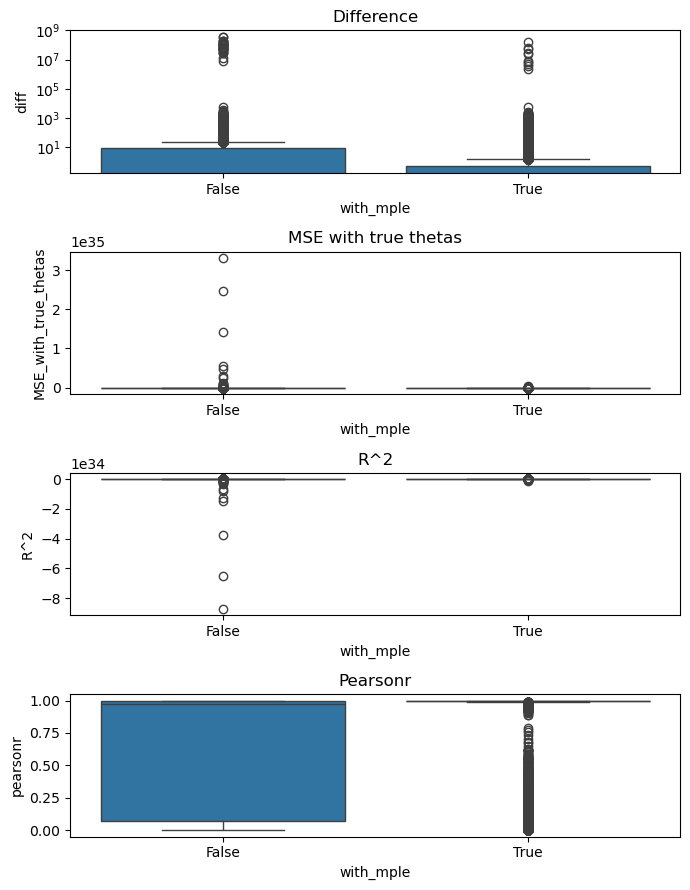

In [12]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7, 9))
sns.boxplot(data=df, x="with_mple", y="diff", ax=ax[0])

sns.boxplot(data=df, x="with_mple", y="MSE_with_true_thetas", ax=ax[1])

sns.boxplot(data=df, x="with_mple", y="R^2", ax=ax[2])

sns.boxplot(data=df, x="with_mple", y="pearsonr", ax=ax[3])

ax[0].set_title("Difference")
ax[1].set_title("MSE with true thetas")
ax[2].set_title("R^2")
ax[3].set_title("Pearsonr")

ax[0].set_yscale("log")

plt.tight_layout()
plt.show()